In [1]:
import mxnet

# Handwritten Digit Recognition

This tutorial guides you through a classic computer vision application: identify hand written digits with neural networks. 

## Load data

We first fetch the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, which is a commonly used dataset for handwritten digit recognition. Each image in this dataset has been resized into 28x28 with grayscale value between 0 and 254. The following codes download and load the images and the according labels into `numpy`.

In [2]:
import numpy as np
import os
import urllib
import gzip
import struct
def download_data(url, force_download=True): 
    fname = url.split("/")[-1]
    if force_download or not os.path.exists(fname):
        urllib.urlretrieve(url, fname)
    return fname

def read_data(label_url, image_url):
    with gzip.open(download_data(label_url)) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(download_data(image_url), 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)

path='http://yann.lecun.com/exdb/mnist/'
(train_lbl, train_img) = read_data(
    path+'train-labels-idx1-ubyte.gz', path+'train-images-idx3-ubyte.gz')
(val_lbl, val_img) = read_data(
    path+'t10k-labels-idx1-ubyte.gz', path+'t10k-images-idx3-ubyte.gz')

We plot the first 10 images and print their labels. 

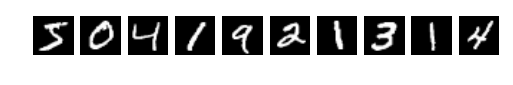

label: [5 0 4 1 9 2 1 3 1 4]


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(train_img[i], cmap='Greys_r')
    plt.axis('off')
plt.show()
print('label: %s' % (train_lbl[0:10],))

Next we create data iterators for MXNet. The data iterator, which is similar the iterator, returns a batch of data in each `next()` call. A batch contains several images with its according labels. These images are stored in a 4-D matrix with shape `(batch_size, num_channels, width, height)`. For the MNIST dataset, there is only one color channel, and both width and height are 28. In addition, we often shuffle the images used for training, which accelerates the training progress.

In [60]:
import mxnet as mx

def to4d(img):
    return img.reshape(img.shape[0], 1, 28, 28).astype(np.float32)/255

batch_size = 60
train_iter = mx.io.NDArrayIter(to4d(train_img), train_lbl, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(to4d(val_img), val_lbl, batch_size)

## Multilayer Perceptron

A multilayer perceptron contains several fully-connected layers. A fully-connected layer, with an *n x m* input matrix *X* outputs a matrix *Y* with size *n x k*, where *k* is often called as the hidden size. This layer has two parameters, the *m x k* weight matrix *W* and the *m x 1* bias vector *b*. It compute the outputs with

$$Y = W X + b.$$

The output of a fully-connected layer is often feed into an activation layer, which performs element-wise operations. Two common options are the sigmoid function, or the rectifier (or "relu") function, which outputs the max of 0 and the input.

The last fully-connected layer often has the hidden size equals to the number of classes in the dataset. Then we stack a softmax layer, which map the input into a probability score. Again assume the input *X* has size *n x m*:

$$ \left[\frac{\exp(x_{i1})}{\sum_{j=1}^m \exp(x_{ij})},\ldots, \frac{\exp(x_{im})}{\sum_{j=1}^m \exp(x_{ij})}\right] $$

Defining the multilayer perceptron in MXNet is straightforward, which has shown as following.

In [76]:
# Create a place holder variable for the input data
data = mx.sym.Variable('data')
# Flatten the data from 4-D shape (batch_size, num_channel, width, height) 
# into 2-D (batch_size, num_channel*width*height)
data = mx.sym.Flatten(data=data)

# The first fully-connected layer
fc1  = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=512)
# Apply relu to the output of the first fully-connnected layer
act1 = mx.sym.Activation(data=fc1, name='relu1', act_type="relu")

# The second fully-connected layer and the according activation function
fc2  = mx.sym.FullyConnected(data=act1, name='fc2', num_hidden = 256)  
act2 = mx.sym.Activation(data=fc2, name='relu2', act_type="relu")

# fc4  = mx.sym.FullyConnected(data=act2, name='fc4', num_hidden = 256)
# act4 = mx.sym.Activation(data=fc4, name='relu4', act_type="relu")

# fc5  = mx.sym.FullyConnected(data=act4, name='fc4', num_hidden = 128)
# act5 = mx.sym.Activation(data=fc5, name='relu5', act_type="tanh")


# The thrid fully-connected layer, note that the hidden size should be 10, which is the number of unique digits
fc3  = mx.sym.FullyConnected(data=act2, name='fc3', num_hidden=10)
# The softmax and loss layer
mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

# We visualize the network structure with output size (the batch_size is ignored.)
shape = {"data" : (batch_size, 1, 28, 28)}
"mx.viz.plot_network(symbol=mlp, shape=shape)"

'mx.viz.plot_network(symbol=mlp, shape=shape)'

Now both the network definition and data iterators are ready. We can start training. 

In [77]:
# Output may vary
import logging
logging.getLogger().setLevel(logging.DEBUG)

model = mx.model.FeedForward(
    symbol = mlp,       # network structure
    num_epoch = 25,     # number of data passes for training 
    learning_rate = 0.33 # learning rate of SGD 
)
model.fit(
    X=train_iter,       # training data
    eval_data=val_iter, # validation data
    batch_end_callback = mx.callback.Speedometer(batch_size, 200) # output progress for each 200 data batches
)

INFO:root:Start training with [cpu(0)]
INFO:root:Epoch[0] Batch [200]	Speed: 3968.36 samples/sec	Train-accuracy=0.395083
INFO:root:Epoch[0] Batch [400]	Speed: 4096.30 samples/sec	Train-accuracy=0.867000
INFO:root:Epoch[0] Batch [600]	Speed: 4093.89 samples/sec	Train-accuracy=0.920000
INFO:root:Epoch[0] Batch [800]	Speed: 4136.58 samples/sec	Train-accuracy=0.944083
INFO:root:Epoch[0] Batch [1000]	Speed: 4023.85 samples/sec	Train-accuracy=0.946917
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=14.790
INFO:root:Epoch[0] Validation-accuracy=0.960479
INFO:root:Epoch[1] Batch [200]	Speed: 4058.09 samples/sec	Train-accuracy=0.957250
INFO:root:Epoch[1] Batch [400]	Speed: 4024.87 samples/sec	Train-accuracy=0.957917
INFO:root:Epoch[1] Batch [600]	Speed: 4113.60 samples/sec	Train-accuracy=0.966667
INFO:root:Epoch[1] Batch [800]	Speed: 3992.46 samples/sec	Train-accuracy=0.969750
INFO:root:Epoch[1] Batch [1000]	Speed: 4056.72 samples/sec	Train-accuracy=0.969333
INFO:root:Ep

After training is done, we can predict a single image. 

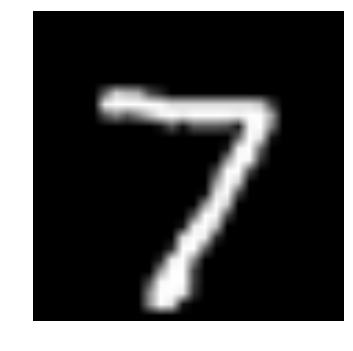

Classified as 7 with probability 0.999980


In [16]:
# Output may vary
plt.imshow(val_img[0], cmap='Greys_r')
plt.axis('off')
plt.show()
prob = model.predict(val_img[0:1].astype(np.float32)/255)[0]
assert max(prob) > 0.99, "Low prediction accuracy."
print 'Classified as %d with probability %f' % (prob.argmax(), max(prob))

We can also evaluate the accuracy given a data iterator. 

In [17]:
# Output may vary
valid_acc = model.score(val_iter)
print 'Validation accuracy: %f%%' % (valid_acc *100,)
assert valid_acc > 0.95, "Low validation accuracy."

Validation accuracy: 97.940000%


Even more, we can recognizes the digit written on the below box. 

In [31]:
from IPython.display import HTML
import cv2
import numpy as np

def classify(img):
    img = img[len('data:image/png;base64,'):].decode('base64')
    img = cv2.imdecode(np.fromstring(img, np.uint8), -1)
    img = cv2.resize(img[:,:,3], (28,28))
    img = img.astype(np.float32).reshape((1,1,28,28))/255.0
    return model.predict(img)[0].argmax()

'''
To see the model in action, run the demo notebook at
https://github.com/dmlc/mxnet-notebooks/blob/master/python/tutorials/mnist.ipynb.
'''
HTML(filename="mnist_demo.html")

## Convolutional Neural Networks

Note that the previous fully-connected layer simply reshapes the image into a vector during training. It ignores the spatial information that pixels are correlated on both horizontal and vertical dimensions. The convolutional layer aims to improve this drawback by using a more structural weight $W$. Instead of simply matrix-matrix multiplication, it uses 2-D convolution to obtain the output. 

<img src="https://thatindiandude.github.io/images/conv.png" style="height: 75%; width: 75%;">

We can also have multiple feature maps, each with their own weight matrices, to capture different features: 
<img src="https://thatindiandude.github.io/images/filters.png" style="height: 75%; width: 75%;">

Besides the convolutional layer, another major change of the convolutional neural network is the adding of pooling layers. A pooling layer reduce a $n\times m$ (often called kernal size) image patch into a single value to make the network less sensitive to the spatial location.

<img src="https://thatindiandude.github.io/images/pooling.png" style="height: 75%; width: 75%;">

In [32]:
data = mx.symbol.Variable('data')
# first conv layer
conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)
tanh1 = mx.sym.Activation(data=conv1, act_type="tanh")
pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))
# second conv layer
conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
tanh2 = mx.sym.Activation(data=conv2, act_type="tanh")
pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))
# first fullc layer
flatten = mx.sym.Flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
tanh3 = mx.sym.Activation(data=fc1, act_type="tanh")
# second fullc
fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=10)
# softmax loss
lenet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')

Note that LeNet is more complex than the previous multilayer perceptron, so we use GPU instead of CPU for training. 

In [34]:
# Output may vary
model = mx.model.FeedForward(
    ctx = mx.gpu(0),     # use GPU 0 for training, others are same as before
    symbol = lenet,       
    num_epoch = 10,     
    learning_rate = 0.1)
model.fit(
    X=train_iter,  
    eval_data=val_iter, 
    batch_end_callback = mx.callback.Speedometer(batch_size, 200)
) 
assert model.score(val_iter) > 0.98, "Low validation accuracy."

INFO:root:Start training with [gpu(0)]


MXNetError: [15:09:08] src/storage/storage.cc:78: Compile with USE_CUDA=1 to enable GPU usage

Stack trace returned 95 entries:
[bt] (0) /home/ganta/mxnet/python/mxnet/../../lib/libmxnet.so(+0xc63fac) [0x7fef9c7f1fac]
[bt] (1) /home/ganta/mxnet/python/mxnet/../../lib/libmxnet.so(+0xc65917) [0x7fef9c7f3917]
[bt] (2) /home/ganta/mxnet/python/mxnet/../../lib/libmxnet.so(_ZN5mxnet11StorageImpl5AllocEmNS_7ContextE+0x4f) [0x7fef9c7f57cf]
[bt] (3) /home/ganta/mxnet/python/mxnet/../../lib/libmxnet.so(MXNDArrayCreateEx+0x530) [0x7fef9c83ecb0]
[bt] (4) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call_unix64+0x4c) [0x7fefc86cde40]
[bt] (5) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call+0x2eb) [0x7fefc86cd8ab]
[bt] (6) /usr/lib/python2.7/lib-dynload/_ctypes.x86_64-linux-gnu.so(_ctypes_callproc+0x48f) [0x7fefc891e3df]
[bt] (7) /usr/lib/python2.7/lib-dynload/_ctypes.x86_64-linux-gnu.so(+0x11d82) [0x7fefc8922d82]
[bt] (8) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (9) /usr/bin/python(PyEval_EvalFrameEx+0x5faf) [0x4c9faf]
[bt] (10) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (11) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (12) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (13) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (14) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (15) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (16) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (17) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (18) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (19) /usr/bin/python() [0x4de6fe]
[bt] (20) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (21) /usr/bin/python() [0x4f492e]
[bt] (22) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (23) /usr/bin/python() [0x4f46a7]
[bt] (24) /usr/bin/python() [0x4b670c]
[bt] (25) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (26) /usr/bin/python(PyEval_EvalFrameEx+0x5faf) [0x4c9faf]
[bt] (27) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (28) /usr/bin/python() [0x4de8b8]
[bt] (29) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (30) /usr/bin/python() [0x4f492e]
[bt] (31) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (32) /usr/bin/python() [0x4f46a7]
[bt] (33) /usr/bin/python() [0x4b670c]
[bt] (34) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (35) /usr/bin/python(PyEval_EvalFrameEx+0x5faf) [0x4c9faf]
[bt] (36) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (37) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (38) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (39) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (40) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (41) /usr/bin/python(PyEval_EvalFrameEx+0x44db) [0x4c84db]
[bt] (42) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (43) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (44) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (45) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (46) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (47) /usr/bin/python() [0x4de8b8]
[bt] (48) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (49) /usr/bin/python(PyEval_EvalFrameEx+0x2ad1) [0x4c6ad1]
[bt] (50) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (51) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (52) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (53) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (54) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (55) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (56) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (57) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (58) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (59) /usr/bin/python() [0x4de8b8]
[bt] (60) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (61) /usr/bin/python(PyEval_EvalFrameEx+0x2ad1) [0x4c6ad1]
[bt] (62) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (63) /usr/bin/python() [0x4de8b8]
[bt] (64) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (65) /usr/bin/python(PyEval_EvalFrameEx+0x2ad1) [0x4c6ad1]
[bt] (66) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (67) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (68) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (69) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (70) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (71) /usr/bin/python() [0x4de8b8]
[bt] (72) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (73) /usr/bin/python(PyEval_EvalFrameEx+0x2ad1) [0x4c6ad1]
[bt] (74) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (75) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (76) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (77) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (78) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (79) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (80) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (81) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (82) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (83) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (84) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (85) /usr/bin/python(PyEval_EvalFrameEx+0x44db) [0x4c84db]
[bt] (86) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (87) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (88) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (89) /usr/bin/python() [0x4de6fe]
[bt] (90) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (91) /usr/bin/python() [0x521eec]
[bt] (92) /usr/bin/python(Py_Main+0x6c8) [0x49e188]
[bt] (93) /lib/x86_64-linux-gnu/libc.so.6(__libc_start_main+0xf0) [0x7fefca778830]
[bt] (94) /usr/bin/python(_start+0x29) [0x49d9d9]


Note that, with the same hyper-parameters, LeNet achieves 98.7% validation accuracy, which improves on the previous multilayer perceptron accuracy of 96.6%.

After training is done on the CNN model, like we did with the perceptron, we can now predict a single image. 

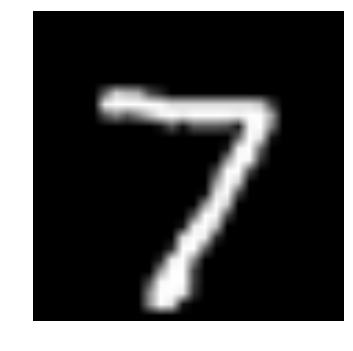

MXNetError: [15:11:03] src/storage/storage.cc:78: Compile with USE_CUDA=1 to enable GPU usage

Stack trace returned 79 entries:
[bt] (0) /home/ganta/mxnet/python/mxnet/../../lib/libmxnet.so(+0xc63fac) [0x7fef9c7f1fac]
[bt] (1) /home/ganta/mxnet/python/mxnet/../../lib/libmxnet.so(+0xc65917) [0x7fef9c7f3917]
[bt] (2) /home/ganta/mxnet/python/mxnet/../../lib/libmxnet.so(_ZN5mxnet11StorageImpl5AllocEmNS_7ContextE+0x4f) [0x7fef9c7f57cf]
[bt] (3) /home/ganta/mxnet/python/mxnet/../../lib/libmxnet.so(MXNDArrayCreateEx+0x530) [0x7fef9c83ecb0]
[bt] (4) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call_unix64+0x4c) [0x7fefc86cde40]
[bt] (5) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call+0x2eb) [0x7fefc86cd8ab]
[bt] (6) /usr/lib/python2.7/lib-dynload/_ctypes.x86_64-linux-gnu.so(_ctypes_callproc+0x48f) [0x7fefc891e3df]
[bt] (7) /usr/lib/python2.7/lib-dynload/_ctypes.x86_64-linux-gnu.so(+0x11d82) [0x7fefc8922d82]
[bt] (8) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (9) /usr/bin/python(PyEval_EvalFrameEx+0x5faf) [0x4c9faf]
[bt] (10) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (11) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (12) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (13) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (14) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (15) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (16) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (17) /usr/bin/python() [0x4de8b8]
[bt] (18) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (19) /usr/bin/python(PyEval_EvalFrameEx+0x2ad1) [0x4c6ad1]
[bt] (20) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (21) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (22) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (23) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (24) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (25) /usr/bin/python(PyEval_EvalFrameEx+0x44db) [0x4c84db]
[bt] (26) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (27) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (28) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (29) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (30) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (31) /usr/bin/python() [0x4de8b8]
[bt] (32) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (33) /usr/bin/python(PyEval_EvalFrameEx+0x2ad1) [0x4c6ad1]
[bt] (34) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (35) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (36) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (37) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (38) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (39) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (40) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (41) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (42) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (43) /usr/bin/python() [0x4de8b8]
[bt] (44) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (45) /usr/bin/python(PyEval_EvalFrameEx+0x2ad1) [0x4c6ad1]
[bt] (46) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (47) /usr/bin/python() [0x4de8b8]
[bt] (48) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (49) /usr/bin/python(PyEval_EvalFrameEx+0x2ad1) [0x4c6ad1]
[bt] (50) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (51) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (52) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (53) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (54) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (55) /usr/bin/python() [0x4de8b8]
[bt] (56) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (57) /usr/bin/python(PyEval_EvalFrameEx+0x2ad1) [0x4c6ad1]
[bt] (58) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (59) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (60) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (61) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (62) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (63) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (64) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (65) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (66) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (67) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (68) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (69) /usr/bin/python(PyEval_EvalFrameEx+0x44db) [0x4c84db]
[bt] (70) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (71) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (72) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (73) /usr/bin/python() [0x4de6fe]
[bt] (74) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (75) /usr/bin/python() [0x521eec]
[bt] (76) /usr/bin/python(Py_Main+0x6c8) [0x49e188]
[bt] (77) /lib/x86_64-linux-gnu/libc.so.6(__libc_start_main+0xf0) [0x7fefca778830]
[bt] (78) /usr/bin/python(_start+0x29) [0x49d9d9]


In [37]:
plt.imshow(val_img[0], cmap='Greys_r')
plt.axis('off')
plt.show()
prob = model.predict(to4d(val_img[0:1]))[0]
print 'Classified as %d with probability %f' % (prob.argmax(), max(prob))

We can also evaluate the accuracy given a data iterator. 

In [36]:
print 'Validation accuracy: %f%%' % (model.score(val_iter)*100,)

MXNetError: [15:10:38] src/storage/storage.cc:78: Compile with USE_CUDA=1 to enable GPU usage

Stack trace returned 79 entries:
[bt] (0) /home/ganta/mxnet/python/mxnet/../../lib/libmxnet.so(+0xc63fac) [0x7fef9c7f1fac]
[bt] (1) /home/ganta/mxnet/python/mxnet/../../lib/libmxnet.so(+0xc65917) [0x7fef9c7f3917]
[bt] (2) /home/ganta/mxnet/python/mxnet/../../lib/libmxnet.so(_ZN5mxnet11StorageImpl5AllocEmNS_7ContextE+0x4f) [0x7fef9c7f57cf]
[bt] (3) /home/ganta/mxnet/python/mxnet/../../lib/libmxnet.so(MXNDArrayCreateEx+0x530) [0x7fef9c83ecb0]
[bt] (4) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call_unix64+0x4c) [0x7fefc86cde40]
[bt] (5) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call+0x2eb) [0x7fefc86cd8ab]
[bt] (6) /usr/lib/python2.7/lib-dynload/_ctypes.x86_64-linux-gnu.so(_ctypes_callproc+0x48f) [0x7fefc891e3df]
[bt] (7) /usr/lib/python2.7/lib-dynload/_ctypes.x86_64-linux-gnu.so(+0x11d82) [0x7fefc8922d82]
[bt] (8) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (9) /usr/bin/python(PyEval_EvalFrameEx+0x5faf) [0x4c9faf]
[bt] (10) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (11) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (12) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (13) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (14) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (15) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (16) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (17) /usr/bin/python() [0x4de8b8]
[bt] (18) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (19) /usr/bin/python(PyEval_EvalFrameEx+0x2ad1) [0x4c6ad1]
[bt] (20) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (21) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (22) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (23) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (24) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (25) /usr/bin/python(PyEval_EvalFrameEx+0x44db) [0x4c84db]
[bt] (26) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (27) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (28) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (29) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (30) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (31) /usr/bin/python() [0x4de8b8]
[bt] (32) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (33) /usr/bin/python(PyEval_EvalFrameEx+0x2ad1) [0x4c6ad1]
[bt] (34) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (35) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (36) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (37) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (38) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (39) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (40) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (41) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (42) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (43) /usr/bin/python() [0x4de8b8]
[bt] (44) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (45) /usr/bin/python(PyEval_EvalFrameEx+0x2ad1) [0x4c6ad1]
[bt] (46) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (47) /usr/bin/python() [0x4de8b8]
[bt] (48) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (49) /usr/bin/python(PyEval_EvalFrameEx+0x2ad1) [0x4c6ad1]
[bt] (50) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (51) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (52) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (53) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (54) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (55) /usr/bin/python() [0x4de8b8]
[bt] (56) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (57) /usr/bin/python(PyEval_EvalFrameEx+0x2ad1) [0x4c6ad1]
[bt] (58) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (59) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (60) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (61) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (62) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (63) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (64) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (65) /usr/bin/python(PyEval_EvalFrameEx+0x68d1) [0x4ca8d1]
[bt] (66) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (67) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (68) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (69) /usr/bin/python(PyEval_EvalFrameEx+0x44db) [0x4c84db]
[bt] (70) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (71) /usr/bin/python(PyEval_EvalFrameEx+0x6099) [0x4ca099]
[bt] (72) /usr/bin/python(PyEval_EvalCodeEx+0x255) [0x4c2765]
[bt] (73) /usr/bin/python() [0x4de6fe]
[bt] (74) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (75) /usr/bin/python() [0x521eec]
[bt] (76) /usr/bin/python(Py_Main+0x6c8) [0x49e188]
[bt] (77) /lib/x86_64-linux-gnu/libc.so.6(__libc_start_main+0xf0) [0x7fefca778830]
[bt] (78) /usr/bin/python(_start+0x29) [0x49d9d9]
